# Classificazione stelle

## Caso di studio
 - Obiettivo del seguente studio è riuscire a classificare delle stelle in *Giant* (Giganti) e *Dwarfs* (Nane), problema di particolare interesse in ambito scientifico-astronomico
 - La scelta del dataset è stata basata sulla quantità e qualità dei dati, infatti i dati provengono dal catalogo VizieR, libreria 
 - Il dataset utilizzato è disponibile sul sito Kaggle al link https://www.kaggle.com/datasets/vinesmsuic/star-categorization-giants-and-dwarfs 
 - Il sistema di classificazione tuttora in uso è conosciuto come *Morgan-Keenan (MK)*, sistema che si basa sulla classificazione di Harvard e aggiunge una classe di luminosità utilizzando i numeri romani.
 Il dataset utilizza la magnitudine assoluta e l'indice di colore B-V per identificare le *giganti* dalle *nane*.

## Importazione delle librerie

Anzitutto importiamo le librerie necessarie per la corretta esecuzione del Notebook

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from urllib.request import urlretrieve
import zipfile

from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score


from ipywidgets import interact

Per la corretta visualizzazione dei grafici generati con Matplotlib aggiungiamo la seguente direttiva:

In [39]:
%matplotlib inline

## Importazione dei dati ed analisi

Come prima cosa scarichiamo i dataset che adopereremo per addestrare il nostro modello classificatore



In [40]:
if not os.path.exists("archive.zip"):
    urlretrieve("https://github.com/giovaz94/datasciencefiles/raw/main/archive.zip", "archive.zip")
    with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
      zip_ref.extractall("./")

Creazione di un nuovo dataframe tramite libreria Pandas e visualizzazione dei primi record

In [107]:
data = pd.read_csv("Star39552_balanced.csv")
data.head(10)

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,10.00,31.66,6.19,1.213,K7V,22.502556,1
1,8.26,3.21,1.00,1.130,K0III,15.792525,0
2,8.27,12.75,1.06,0.596,F9V,18.797552,1
3,6.54,5.23,0.76,1.189,K1III,15.132508,0
4,8.52,0.96,0.72,0.173,B8V,13.431356,1
5,6.09,6.02,0.95,0.040,B8IVn,14.987983,1
6,7.94,5.36,0.61,1.066,K0III,16.585825,0
7,6.81,13.13,1.04,1.030,K1III,17.401323,0
8,7.68,0.66,0.62,0.013,B2V:e,11.777719,1
9,8.78,8.26,1.14,0.682,G2IV,18.364899,1


### Descrizione del dataset
Analizziamo le informazioni fornite dal dataset.
Innanzitutto ricordiamo che la magnitudine di una stella specifica la quantità di luce di un corpo celeste.

Il dataset adoperato presenta le seguenti informazioni: 

- `Vmag`: **magnitudine apparente**: Luminosità misurata da un'osservatore dalla superficie terrestre.
- `Plx`: Distanza tra la stella e la terra
- `e_Plx`: Errore relativo alla colonna Plx
- `B-V`: **B-V color index** : Indice numerico rappresentante la temperatura di una stella. Una stella "fredda" tende ad avere un indice positivo mentre, al contrario, una stella "calda" tende ad averne uno negativo. Le stelle calde tendono ad essere più luminose nella parte dello spettro luminoso blu rispetto a quello rosso e questo giustifica, dunque, l'espressione $B-V$. 
- `SpType`: **Spectral Type**: Classe che rappresenta lo spettro di temperatura a cui la stella appartiene
- `Amag`: **magnitudine assoluta**: Luminosità di un corpo celeste se tutti fossero a una distanza fissata *(10 Parsec)* dalla Terra.
Il legame tra Amag(M) e Vmag(m) è definito dalla seguente relazione: $$ M = m - 5 log_{10} d + 5 $$
- `TargetClass`: Classe a cui appartiene la stella
  - Valore $0$: La stella è classificata come "nana".
  - Valore $1$: La stella è classificata come "gigante".

Prima di procedere facciamo alcune verifiche per assicurarci che i dati siano utilizzabili.

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39552 entries, 0 to 39551
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vmag         39552 non-null  float64
 1   Plx          39552 non-null  float64
 2   e_Plx        39552 non-null  float64
 3   B-V          39552 non-null  float64
 4   SpType       39552 non-null  object 
 5   Amag         39552 non-null  float64
 6   TargetClass  39552 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 2.1+ MB


Notiamo che i tipi di dato coincidono con le nostre aspettative, quindi procediamo ora a controllare più nel dettaglio alcune statistiche relative ad ogni colonna.

In [108]:
# Sommario statistico dei valori.
data[['Vmag','Amag','Plx','e_Plx','B-V']].describe()

,Vmag,Amag,Plx,e_Plx,B-V
count,39552.000000,39552.000000,39552.000000,39552.000000,39552.000000
mean,7.921309,16.050687,7.117378,1.109705,0.744336
std,1.308857,2.443937,12.446291,0.788133,0.513987
min,-0.620000,-0.350000,-27.840000,0.420000,-0.400000
25%,7.210000,14.756514,2.430000,0.800000,0.358000
50%,8.160000,16.020827,4.440000,0.990000,0.703000
75%,8.830000,17.590542,8.232500,1.230000,1.129000
max,12.850000,30.449015,772.330000,40.630000,3.440000


### Analisi esplorativa

Anzitutto vogliamo osservare la distribuzione dei dati nel nostro dataset visualizzando il numero di stelle appartenenti a ciascuna classe 

In [44]:
data["TargetClass"].value_counts()

1    19776
0    19776
Name: TargetClass, dtype: int64

<AxesSubplot:ylabel='TargetClass'>

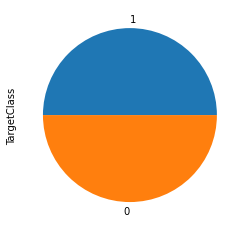

In [45]:
data["TargetClass"].value_counts(normalize=True).plot.pie()

Le classi appaiono perfettamente bilanciate, non ci sarà quindi bisogno di aumentare il peso degli errori sulla classe con meno istanze.

## Analisi di correlazione delle variabili predittive.
Vogliamo analizzare ora il livello di correlazione tra le variabili predittive date in input e la classe che dobbiamo predire. A tal proposito creiamo una funzione che mostra dei grafici a dispersione in cui viene evidenziato quanto ciascuna tipologia di variabile influisca nel predire la classe di una determinata stella. 


In [46]:
def per_class_correlation_graphs(dataset):
  """
  Show correlation graphs of a given dataset
  @param dataset: Input dataset
  """

  # Create a subplot region
  _, pos = plt.subplots(2, 3, figsize=(20,10))

  # Comparsion between Vmag and Amag
  sns.scatterplot(data = dataset, x = 'Vmag', y= 'Amag', ax=pos[0][0], hue = 'TargetClass')

  # Comparsion between Vmag and Plx
  sns.scatterplot(data = dataset, x = 'Vmag', y= 'Plx', ax=pos[0][1], hue = 'TargetClass')

  # Comparsion between Vmag and B-V
  sns.scatterplot(data = dataset, x = 'Vmag', y= 'B-V', ax=pos[0][2], hue = 'TargetClass')

  # Comparsion between Amag and Plx
  sns.scatterplot(data = dataset, x = 'Amag', y= 'Plx', ax=pos[1][0], hue = 'TargetClass')

  # Comparsion between Amag and B-V
  sns.scatterplot(data = dataset, x = 'Amag', y= 'B-V', ax=pos[1][1], hue = 'TargetClass')

  # Comparsion between B-V and Plx
  sns.scatterplot(data = dataset, x = 'B-V', y= 'Plx', ax=pos[1][2], hue = 'TargetClass')



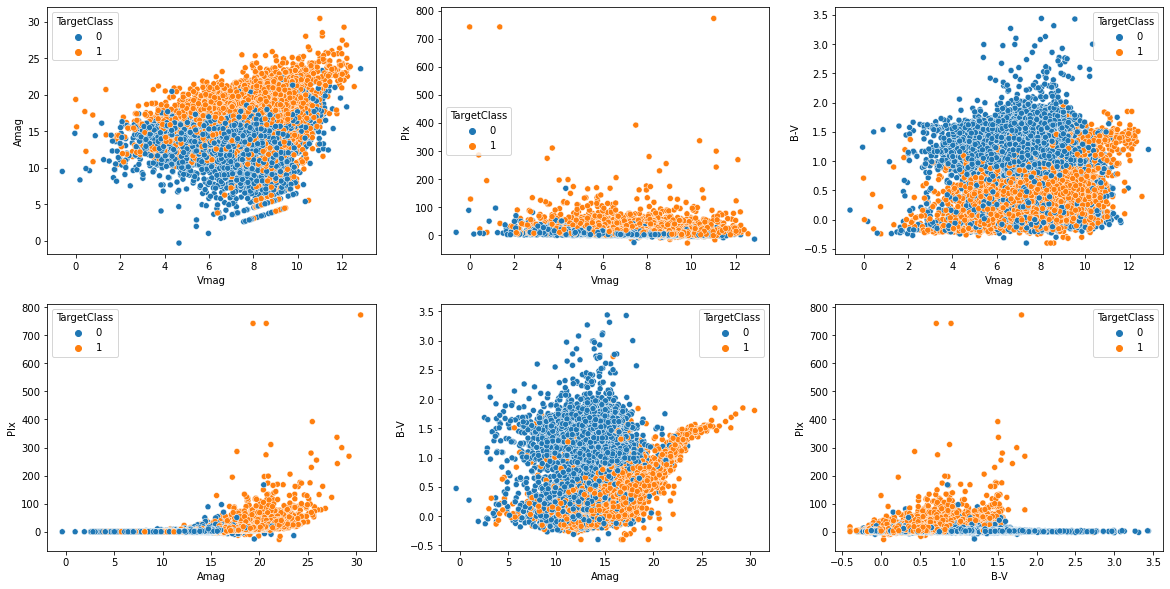

In [47]:
per_class_correlation_graphs(data)

Dai grafici è possibile notare che vi è una forte correlazione tra i valori di: 
- Vmag e Plx / Amag e Plx.
- Vmag e B-V / Amag e B-V.

Non sono stati considerati i valori relativi alla colonna e_Plx in quanto rappresentativi di un errore di rilevazione dei dati.

### Filtraggio dati

Vogliamo a questo punto filtrare i dati affetti da un errore maggiore di una determinata soglia. A tal proposito vogliamo adoperare le informazioni della colonna e_Plx. 

Una volta adoperata possiamo scartarla dal nostro dataset

In [109]:
def filter_dataset(dataset, threshold):
  """
  Remove all the records that contains a relative error higher than the mean of e_Plx plus a certain threshold and then return a new dataset 
  with the e_Plx and SpType columns removed.
  @param dataset: the input dataset
  @param threshold: the input threshold
  """
  filtered_dataset = dataset[ dataset['e_Plx'] < dataset['e_Plx'].mean() + threshold]
  return filtered_dataset.drop(['e_Plx', 'SpType'], axis = 1)

#### Selezione della soglia

Predisposta la funzione per ottenere un dataset aggiornato con dati non affetti da un errore maggiore di una determinata soglia $\sigma$ vogliamo ottenere un valore ottimale di quest'ultima. 

Occorre, a tal proposito osservare la distribuzione dell'errore nei nostri dati

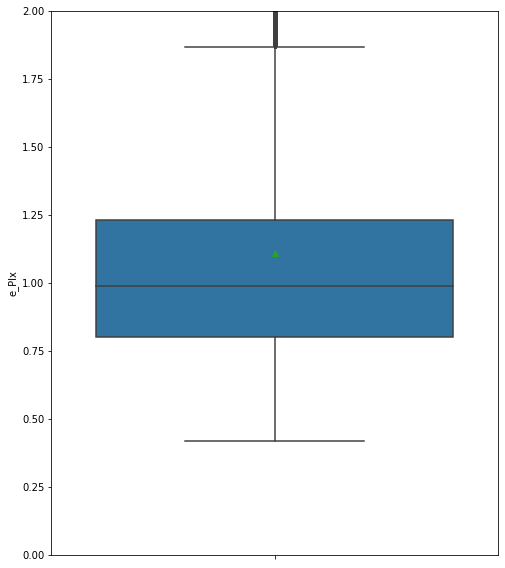

In [110]:
plt.figure(figsize=(8,10))
box = sns.boxplot(y=data["e_Plx"], showmeans=True)
box.set(ylim=(0, 2));

Notiamo che l'errore dei nostri valori centrali è compreso tra un minimo di circa 0.8 ed un massimo di 1.23. Calcoliamo la media ( triangolo verde ) risulta essere di circa 1.10. 

In [111]:
# Informazoni colonna errore e_Plx
data['e_Plx'].describe()

count    39552.000000
mean         1.109705
std          0.788133
min          0.420000
25%          0.800000
50%          0.990000
75%          1.230000
max         40.630000
Name: e_Plx, dtype: float64

Da questi dati possiamo già attribuire un limite inferiore a $\sigma$: 
- L'errore accettabile deve essere maggiore di almeno $1.23$, dunque $mean + \sigma \ge 1.23 \Rightarrow \sigma \ge 0.13$

Il valore massimo di e_Plx dei dati ordinari risulta essere di circa $1.80$:
- Possiamo porre come limite superiore di $\sigma$ un valore tale per cui $mean + \sigma \le 1.80$ ovvero $0.70$.  

In conclusione: $0.13 \le \sigma \le 0.70$. 

Selezioniamo un valore di $\sigma$ che ci permetta di avere un numero soddisfacente di record. 

In [112]:
@interact(sigma=(0.13,0.70))
def test_sigma(sigma):
  out_dataset = filter_dataset(data, sigma)
  print(f"Number of records:{len(out_dataset)}")

interactive(children=(FloatSlider(value=0.415, description='sigma', max=0.7, min=0.13), Output()), _dom_classe…

Un valore che risulta accettabile è $0.43$. Procediamo dunque a creare un dataset filtrato con questo valore di threshold.

In [113]:
𝜎 = 0.43
filtered_dataset = filter_dataset(data, 𝜎)

## Creazione set di test e validazione 

Definiamo di seguito i vari test e validation sets che adopereremo durante l'addestramento dei modelli.

In [114]:
y = filtered_dataset["TargetClass"]   # Contiene i risultati della classificazione
X = filtered_dataset.iloc[:, :-1]     # Features su cui effettuiamo l'addestramento 

# Creazione dei modelli di train e validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=30)


## Accuratezza modelli

Per l'analisi dell'accuratezza della classificazione dei nostri modelli definiamo una funzione che ci permette di mostrare una matrice di confusione e, successivamente mostrare le percentuali di recall, precision e la misura F1.

In [115]:
def show_model_stats(model, X, y):
    # Mostra la matrice di confusione
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plot_confusion_matrix(model, X, y, labels=[0,1])
    
    # Statistiche di precision, recall e F1
    
    precision = [
        precision_score(y, y_pred, pos_label=x) for x in [0,1]
    ]
    print(f"Precision per classificazione di stelle Nane (label: 0) : {precision[0]}")
    print(f"Precision per classificazione di stelle Giganti (label: 1): {precision[1]}")
    
    
    recall = [
        recall_score(y, y_pred, pos_label=x) for x in [0,1]
    ]
    print(f"Recall per classificazione di stelle Nane (label: 0): {recall[0]}")
    print(f"Recall per classificazione di stelle Giganti (label: 1):  {recall[1]}")
    
    f1 = f1_score(y, y_pred, average="macro")
    
    print(f"Score F1: {f1}")
    

## Perceptron

Il perceptron è un algoritmo elementare in cui la retta di classificazione $wx^{T} + b$ è inizializzata casualmente e viene man mano modificata nei parametri relativi a i coefficienti $w$ e all'intercetta $b$ mentre si itera il training set.

Definiamo un nuovo modello tramite una pipeline in cui, anzitutto, standardizzeremo le nostre variabili e, successivamente il risultato verrà applicato ad un classificatore `Perceptron` a cui aggiungiamo una regolarizzazione l1 per le variabili: 

In [131]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron", Perceptron(random_state=42, penalty="l1", l1_ratio = 0.30))
])
model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('perceptron',
                 Perceptron(l1_ratio=0.3, penalty='l1', random_state=42))])

Otteniamo dunque un modello da cui possiamo estrarre alcuni dati come ad esempio il valore dei pesi $W$ e dell'intercetta $b$

In [132]:
W = model.named_steps['perceptron'].coef_[0]
b = model.named_steps['perceptron'].intercept_[0]
print(f"W: {W}")
print(f"b: {b}")

W: [ 0.5619749   1.92904754 -2.64244632  0.        ]
b: 0.0


- Ad esempio questi coefficienti indicano che l'iperpiano individuato dal modello è descritto dall'equazione
$$ 0.5619749x_1+1.92904754x_2-2.64244632+0x_4 - 0 = 0 $$
- L'attributo `classes_` mostra le classi riconosciute dal classificatore
  - la prima è quella a cui sono assegnati i punti sotto la retta, la seconda quella a cui sono assegnati i punti sopra

In [133]:
model.classes_

array([0, 1])

Calcoliamo ora l'accuratezza del modello utilizzando la funzione score

In [134]:
model.score(X2_val, y_val)

0.838483620398514

Otteniamo un'accuratezza del 83%, la quale viene confermata dalla matrice di confusione:

Precision per classificazione di stelle Nane (label: 0) : 0.8511290322580645
Precision per classificazione di stelle Giganti (label: 1): 0.8245924875974486
Recall per classificazione di stelle Nane (label: 0): 0.8420296792723792
Recall per classificazione di stelle Giganti (label: 1):  0.8344988344988346
Score F1: 0.8380354954297061


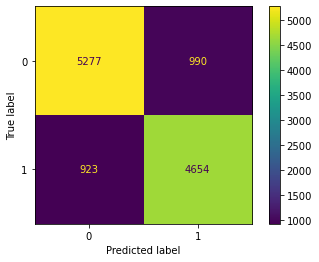

In [135]:
show_model_stats(model, X2_val, y_val)

Analizziamo ora la capacità del modello a classificare nuovi dati in ingresso attraverso K-fold cross validation

In [138]:
split_number = 6 
kfolds = KFold(split_number, shuffle=True, random_state = 33)
kval_results = cross_validate(model, X, y, cv=kfolds, return_train_score=True)
df_kval_results = pd.DataFrame(kval_results)
df_kval_results[['test_score', 'train_score']].agg(['mean', 'std'])

,test_score,train_score
mean,0.809468,0.810256
std,0.046044,0.044499


## Regressione logistica
Proviamo ora a migliorare i dati utilizzando un modelli più complessi.

Addestriamo un modello di regressione logistica con standardizzazione dei dati.

In [139]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
    solver="saga", random_state=30,
    penalty="elasticnet", C=0.1, l1_ratio=0.2))
])
model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.1, l1_ratio=0.2, penalty='elasticnet',
                                    random_state=30, solver='saga'))])

A questo punto conosciamo la probabilità che un'osservazione del dataset appartenga o meno ad una classe.

Sapendo che $ 0 $ equivale a una stella nana e $ 1 $ a una gigante, vediamo per le prime 10 osservazioni con quanta probabilità ciascuna di esse appartiene a una classe.

In [140]:
model.predict_proba(X_val[:10])

array([[0.07773676, 0.92226324],
       [0.03967862, 0.96032138],
       [0.20344662, 0.79655338],
       [0.97407839, 0.02592161],
       [0.13227988, 0.86772012],
       [0.08529207, 0.91470793],
       [0.84593486, 0.15406514],
       [0.14989228, 0.85010772],
       [0.9681942 , 0.0318058 ],
       [0.08876943, 0.91123057]])

Calcoliamo l'accuratezza del modello

In [141]:
model.score(X_val, y_val)

0.8851739277271192

Come possiamo notare l'accuratezza è migliorata rispetto al modello Perceptron usato precedentemente.

Precision per classificazione di stelle Nane (label: 0) : 0.9054701702197984
Precision per classificazione di stelle Giganti (label: 1): 0.8639737614362161
Recall per classificazione di stelle Nane (label: 0): 0.8742620073400351
Recall per classificazione di stelle Giganti (label: 1):  0.8974358974358975
Score F1: 0.8849897247994118


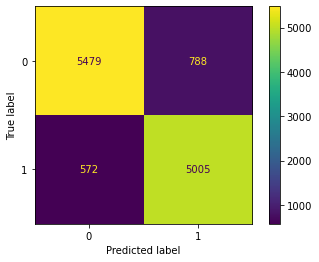

In [142]:
show_model_stats(model, X_val, y_val)

In [ ]:
#calcolare f1, precision e recall

Dalla matrice di confusione possiamo ricavare quante istanze del valida

Siccome vogliamo testare diverse soluzioni creiamo una griglia di parametri, che ci permette di testare la `LogisticRegression` su:
- diversi tipi di regolarizzazione: *L2*, *L1*, *ElasticNet*
- diversi valori per il parametro C e *l1_ratio*


In [143]:
model =  Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga"))
])
grid =  [
    {
        "lr__penalty": ["l2", "l1"],
        "lr__C": [0.1, 1, 10]
    },
    {
        "lr__penalty": ["elasticnet"],
        "lr__C": [0.1, 1, 10],
        "lr__l1_ratio": [0.2, 0.5]
    }
]
gs = GridSearchCV(model, grid)
gs.fit(X_train, y_train);

/Users/giovanniantonioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/giovanniantonioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/giovanniantonioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/giovanniantonioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/giovanniantonioni/opt/anacond

/Users/giovanniantonioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/giovanniantonioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/giovanniantonioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/giovanniantonioni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/giovanniantonioni/opt/anacond

Visualizziamo i parametri migliori che la ricerca tramite grid search ha prodotto:

In [144]:
gs.best_params_

{'lr__C': 1, 'lr__penalty': 'l2'}

In [145]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.169846,0.045894,0.001830,0.000239,1,l2,NaN,"{'lr__C': 1, 'lr__penalty': 'l2'}",0.87442,0.881173,0.877797,0.883682,0.879460,0.879306,0.003125,1
3,0.189264,0.051004,0.002188,0.000431,1,l1,NaN,"{'lr__C': 1, 'lr__penalty': 'l1'}",0.87442,0.881173,0.877797,0.883682,0.879460,0.879306,0.003125,1
4,0.168826,0.043080,0.001616,0.000132,10,l2,NaN,"{'lr__C': 10, 'lr__penalty': 'l2'}",0.87442,0.881173,0.877797,0.883471,0.879671,0.879306,0.003070,1
8,0.202203,0.055582,0.002161,0.000373,1,elasticnet,0.2,"{'lr__C': 1, 'lr__l1_ratio': 0.2, 'lr__penalty...",0.87442,0.881173,0.877797,0.883682,0.879460,0.879306,0.003125,1
9,0.191466,0.053673,0.002067,0.000372,1,elasticnet,0.5,"{'lr__C': 1, 'lr__l1_ratio': 0.5, 'lr__penalty...",0.87442,0.881173,0.877797,0.883682,0.879460,0.879306,0.003125,1


## SVM

Addestriamo un modello di classificazione SVM, definendone uno avente una configurazione standard

In [146]:
model = Pipeline([
    ("scaler", StandardScaler()),           # Standardizzazione delle features.
    ("support_vector", SVC(gamma='auto'))   # SVC adopera di default il kernel rbf per la trasformazione delle variabili
])

Effettuiamo l'addestramento richiamando il metodo fit

In [147]:
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('support_vector', SVC(gamma='auto'))])

Calcoliamo ora lo score ottenuto con i validation set

In [84]:
model.score(X_val, y_val)

0.8880445795339412

Mostriamo i primi risultati ottenuti

Precision per classificazione di stelle Nane (label: 0) : 0.914582983722101
Precision per classificazione di stelle Giganti (label: 1): 0.8611724723874257
Recall per classificazione di stelle Nane (label: 0): 0.8696345939045795
Recall per classificazione di stelle Giganti (label: 1):  0.9087322933476779
Score F1: 0.8879279987273931


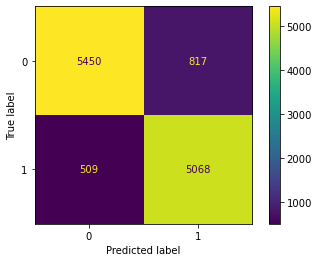

In [85]:
show_model_stats(model, X_val, y_val)

Il modello riesce a classificare correttamente l'88% dei dati passatti. 
Analizziamo ora il suo comportamento su nuovi dati eseguendo una KFold cross validation.

Per questo test effettuiamo lo split dei dati in 6 gruppi distinti e richiamiamo la funzione `cross_validate` visualizzando lo score medio ottenuto sia sul set di train e di validation:

In [36]:
split_number = 6  # Split del modello in 6 folds 
kfolds = KFold(split_number, shuffle=True, random_state = 33)
kval_results = cross_validate(model, X, y, cv=kfolds, return_train_score=True)
df_kval_results = pd.DataFrame(kval_results)
df_kval_results[['test_score', 'train_score']].agg(['mean', 'std'])

,test_score,train_score
mean,0.883007,0.884003
std,0.002069,0.000530


Anche in questo caso abbiamo ottenuto un risultato particolarmente buono, infatti sia su test che train otteniamo sempre uno score del circa 88%. 

### Gridsearch 

Passiamo ora all'identificazione di una configurazione ottimale per il nostro modello SVM attraverso grid search.


#### Parametri SVC:

- $C$ (Regularization Parameter): È il parametro di regolarizzazione delle variabili di slack : 
$$ 
  \frac{w^{T}w}{2} + C \sum_{i} \xi_{i}
$$
- Kernels: Sono le funzioni che vengono usate da svm per definire l'iperpiano in più dimensioni senza intaccare la complessità computazionale.

- $\gamma$: Coefficienti per i kernel rbf, poly e sigmoid.



In [37]:
# Reguralization parameter
C_Params = [1.0, 1.2, 1.4, 2.0, 4.0]

# Kerles
kernels = ['rbf', 'poly', 'sigmoid','linear']

# Gamma
gamma = ['scale', 'auto']

# Modello standard
model = Pipeline([
    ("scaler", StandardScaler()),                         
    ("svm", SVC())   
])

# GridSearch
grid = {
    "svm__C": C_Params,
    "svm__kernel": kernels,
    "svm__gamma": gamma
}

gs = GridSearchCV(model, grid, cv=kfolds, n_jobs=-1)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

KeyboardInterrupt: 

Il migliori parametri per il modello di classificazione tramite SVM sono: 

In [ ]:
gs.best_params_

Lo score ottenuto è, invece:

In [ ]:
gs.best_score_

## Incremento della precisione del modello adoperando lo spectral type 

All'interno del nostro dataset vi è una colonna denominata `SpType` la quale possiede al suo interno dei dati categorici relativi alla classe spettrale di temperatura a cui una determinata stella appartiene.
Il range di valori che questa può assumere sono riassunti al seguente [link](https://en.wikipedia.org/wiki/Stellar_classification). 

Vogliamo di seguito mostrare come l'utilizzo di questa feature incrementi notevolmente la capacità di classificazione dei nostri modelli. 

Per poter usufruire dei dati relativi a `SpType` occorre aggiungere al nostro dataset tante colonne booleane per quante tipologie di valori di `SpType` i nostri dati possono assumere. Per evitare di creare un dataframe di dimensioni eccessive consideriamo solo i primi 40 valori più numerosi. 

In [93]:
data = pd.read_csv("Star39552_balanced.csv")
sptype_count = data["SpType"].value_counts()[:40]
sptype_count

K0III       2841
K1III       1742
K2III       1479
G8III       1474
K3III       1097
F5V          973
F3V          761
A0V          722
K4III        612
F6V          608
F7V          562
B9V          556
F0V          542
G3V          530
F2V          510
K5III        506
G0V          491
G5V          488
A1V          419
G8/K0III     392
F8V          387
G2V          349
K2/K3III     342
B8V          313
G1V          295
M1III        291
G8V          290
M2III        282
A2V          265
K1/K2III     250
A3V          246
M0III        225
G6III        221
G8IV         221
F3/F5V       218
K0V          215
B9.5V        205
G8III/IV     199
A9V          199
K0/K1III     189
Name: SpType, dtype: int64

Passiamo ora alla creazione delle colonne: 

In [94]:
keys = sptype_count.keys()
for k in keys:
    data[f"{k}_bool"] = data["SpType"] == k

Visualizziamo il nostro dataset risultante

In [95]:
data

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,K0III_bool,K1III_bool,K2III_bool,...,A3V_bool,M0III_bool,G6III_bool,G8IV_bool,F3/F5V_bool,K0V_bool,B9.5V_bool,G8III/IV_bool,A9V_bool,K0/K1III_bool
0,10.00,31.66,6.19,1.213,K7V,22.502556,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,8.26,3.21,1.00,1.130,K0III,15.792525,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,8.27,12.75,1.06,0.596,F9V,18.797552,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6.54,5.23,0.76,1.189,K1III,15.132508,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,8.52,0.96,0.72,0.173,B8V,13.431356,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39547,5.83,0.17,0.52,0.474,B7Iab,6.982245,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
39548,7.05,18.12,0.92,0.424,F5V,18.340790,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
39549,9.21,3.89,1.46,0.227,A1IV,17.159748,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
39550,9.01,2.13,1.46,1.467,M5III,15.651898,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Creiamo ora un nuovo dataset filtrato come in precedenza ed addestriamo nuovamente il nostro classificatore svm.

In [104]:
𝜎 = 0.43
filtered_dataset = filter_dataset(data, 𝜎)

y = filtered_dataset["TargetClass"]   # Contiene i risultati della classificazione
X = filtered_dataset.iloc[:, :-1]     # Features su cui effettuiamo l'addestramento 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=30)

model = Pipeline([
    ("scaler", StandardScaler()),           
    ("support_vector", SVC(gamma='auto'))  
])

model.fit(X_train, y_train)

split_number = 6  # Split del modello in 6 folds 
kfolds = KFold(split_number, shuffle=True, random_state = 33)
kval_results = cross_validate(model, X, y, cv=kfolds, return_train_score=True)
df_kval_results = pd.DataFrame(kval_results)
df_kval_results[['test_score', 'train_score']].agg(['mean', 'std'])

,test_score,train_score
mean,0.999972,0.999972
std,0.000069,0.000014


Il nostro score nei dati di validazione risulta essere molto elevato 99%. 
Mostriamo ora la matrice di dispersione per visualizzare quante istanze dei nostri dati siano state effettivamente classificate correttamente: 

Precision per classificazione di stelle Nane (label: 0) : 1.0
Precision per classificazione di stelle Giganti (label: 1): 1.0
Recall per classificazione di stelle Nane (label: 0): 1.0
Recall per classificazione di stelle Giganti (label: 1):  1.0
Score F1: 1.0


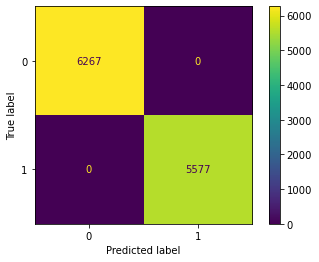

In [105]:
show_model_stats(model, X_val, y_val)